# Cross-Correlation Analysis for Lag Time Distribution

In [2]:
import numpy as np
import pandas as pd
import dataretrieval.nwis as nwis
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import math
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms

In [3]:
int_freq = 30 #15

In [4]:
def deduplicate_data(df):

    # Remove data not on the int_freq min interval
    if int_freq == 15:
        df = df[df.index.minute.isin([0, 15, 30, 45]) & (df.index.second == 0) & (df.index.microsecond == 0)]
    if int_freq == 30:
        df = df[df.index.minute.isin([0, 30]) & (df.index.second == 0) & (df.index.microsecond == 0)]

    old_len = len(df)
    
    # Identify all duplicated rows based on the datetime index
    duplicate_rows = df[df.index.duplicated(keep=False)]  # keep=False keeps all copies
    
    # Extract unique dates (without time) from duplicated timestamps
    duplicate_dates = np.unique(duplicate_rows.index.date)
    
    # Print results
    print("Duplicate Dates:")
    for date in duplicate_dates:
        print(f"  - {date}")
    print("\nDuplicated Data:")
    print(duplicate_rows)

    # Remove duplicates
    df = df[~df.index.duplicated(keep='first')]

    new_len = len(df)
    removed_rows = old_len - new_len
    
    print(f"Removed {removed_rows} rows")
    print()
    
    return df


In [5]:
def drop_nan(df):
    before = len(df)
    df_cleaned = df.dropna(subset=['00065'])
    after = len(df_cleaned)
    removed = before - after
    print(f"Removed {removed} rows with NaN in '00065'")
    print()
    return df_cleaned

In [6]:
def impute_missing_data(df):

    freq=str(int_freq) + 'min'
    
    # Create full expected range at specified frequency
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)

    # Find missing timestamps
    missing = full_range.difference(df.index)

    # Print missing days report
    missing_days = pd.Series(missing.date).unique()
    if len(missing_days) > 0:
        print("Missing data on the following days:")
        for day in missing_days:
            print(f"- {day}")
    else:
        print("No missing days.")

    imputed_count = 0

    # Impute missing values using average of the endpoints
    for missing_time in missing:
        # Find the two nearest data points surrounding the missing timestamp
        prev_point = df[df.index <= missing_time].iloc[-1:]  # Last point before the missing timestamp
        next_point = df[df.index > missing_time].iloc[:1]    # First point after the missing timestamp

        if not prev_point.empty and not next_point.empty:
            avg_value = (prev_point['00065'].values[0] + next_point['00065'].values[0]) / 2
            df.loc[missing_time] = avg_value
            imputed_count += 1
            print(f"Imputed missing data at {missing_time} with value {avg_value:.2f}")
        elif not prev_point.empty:
            df.loc[missing_time] = prev_point['00065'].values[0]
            imputed_count += 1
            print(f"Imputed missing data at {missing_time} with value {prev_point['00065'].values[0]:.2f}")
        elif not next_point.empty:
            df.loc[missing_time] = next_point['00065'].values[0]
            imputed_count += 1
            print(f"Imputed missing data at {missing_time} with value {next_point['00065'].values[0]:.2f}")
        else:
            print(f"Unable to impute missing data at {missing_time}.")

    print(f"\nImputed {imputed_count} rows")

    # Resort imputed data
    df = df.sort_index()

    return df

## USGS Stream Gauge Data Collection & Preprocessing
Reference: https://github.com/DOI-USGS/dataretrieval-python

In [8]:
start_date = '2009-01-01'
end_date = '2024-12-31'

start_date_obj = datetime.strptime(start_date, '%Y-%m-%d') 
start_new_format = start_date_obj.strftime('%m-%d-%Y') 
end_date_obj = datetime.strptime(end_date, '%Y-%m-%d') 
end_new_format = end_date_obj.strftime('%m-%d-%Y') 

date_range = start_new_format + ' to ' + end_new_format

### Downstream Data (Inflow)

In [10]:
inflow_site = '14128600'
print(nwis.get_record(sites=inflow_site, service='site').station_nm[0])

COLUMBIA RIVER AT STEVENSON, WA


In [11]:
# Get instantaneous values (iv)
df = nwis.get_record(sites=inflow_site, service='iv', start=start_date, end=end_date)
df.index = df.index.tz_convert('America/Los_Angeles')  # Convert to Pacific Time
df.index = df.index.tz_localize(None) # Remove timezone info 
df = df[['site_no','00065']]

# Deduplicate data
df = deduplicate_data(df)

# Remove NaNs
df = drop_nan(df)

# Impute missing data
df = impute_missing_data(df)

Duplicate Dates:
  - 2013-11-03
  - 2014-11-02
  - 2015-11-01
  - 2016-11-06
  - 2017-11-05
  - 2018-11-04
  - 2019-11-03
  - 2020-11-01
  - 2021-11-07
  - 2022-11-06
  - 2023-11-05
  - 2024-11-03

Duplicated Data:
                      site_no  00065
datetime                            
2013-11-03 01:00:00  14128600  75.59
2013-11-03 01:30:00  14128600  75.54
2013-11-03 01:00:00  14128600  75.47
2013-11-03 01:30:00  14128600  75.45
2014-11-02 01:00:00  14128600  75.65
2014-11-02 01:30:00  14128600  75.61
2014-11-02 01:00:00  14128600  75.57
2014-11-02 01:30:00  14128600  75.55
2015-11-01 01:00:00  14128600  73.53
2015-11-01 01:30:00  14128600  73.42
2015-11-01 01:00:00  14128600  73.34
2015-11-01 01:30:00  14128600  73.25
2016-11-06 01:00:00  14128600  73.45
2016-11-06 01:30:00  14128600  73.38
2016-11-06 01:00:00  14128600  73.33
2016-11-06 01:30:00  14128600  73.25
2017-11-05 01:00:00  14128600  75.22
2017-11-05 01:30:00  14128600  75.25
2017-11-05 01:00:00  14128600  75.17
2017-11-

### Upstream Data (Outflow)

In [13]:
outflow_site = '14105700'
print(nwis.get_record(sites=outflow_site, service='site').station_nm[0])

COLUMBIA RIVER AT THE DALLES, OR


In [14]:
# Get instantaneous values (iv)
df2 = nwis.get_record(sites=outflow_site, service='iv', start=start_date, end=end_date)
df2.index = df2.index.tz_convert('America/Los_Angeles')  # Convert to Pacific Time
df2.index = df2.index.tz_localize(None) # Remove timezone info 
df2 = df2[['site_no','00065']]

# Deduplicate data
df2 = deduplicate_data(df2)

# Remove NaNs
df2 = drop_nan(df2)

# Impute missing data
df2 = impute_missing_data(df2)

Duplicate Dates:
  - 2009-11-01
  - 2010-11-07
  - 2011-11-06
  - 2012-11-04
  - 2013-11-03
  - 2014-11-02
  - 2015-11-01
  - 2016-11-06
  - 2017-11-05
  - 2018-11-04
  - 2019-11-03
  - 2020-11-01
  - 2021-11-07
  - 2022-11-06
  - 2023-11-05
  - 2024-11-03

Duplicated Data:
                      site_no  00065
datetime                            
2009-11-01 01:00:00  14105700  77.60
2009-11-01 01:30:00  14105700  77.71
2009-11-01 01:00:00  14105700  77.62
2009-11-01 01:30:00  14105700  77.54
2010-11-07 01:00:00  14105700  76.83
...                       ...    ...
2023-11-05 01:30:00  14105700  75.89
2024-11-03 01:00:00  14105700  76.40
2024-11-03 01:30:00  14105700  76.39
2024-11-03 01:00:00  14105700  76.27
2024-11-03 01:30:00  14105700  76.24

[64 rows x 2 columns]
Removed 32 rows

Removed 437 rows with NaN in '00065'

Missing data on the following days:
- 2009-01-26
- 2009-01-31
- 2009-02-03
- 2009-02-04
- 2009-02-07
- 2009-02-10
- 2009-02-11
- 2009-02-15
- 2009-02-22
- 2009-02-25


## Data Visualization: Preprocessing

In [16]:
## Isolate streamflow gauage series

# df: Stevenson, downstream, inflow
# df2: Dallas Dam, upstream, outflow

x = df2['00065'].to_numpy() ## OUTFLOW
y = df['00065'].to_numpy() ## INFLOW
dates = df.index

# Check if same length
print(len(x), len(y))

280512 280512


### Plot #1: Streamflow

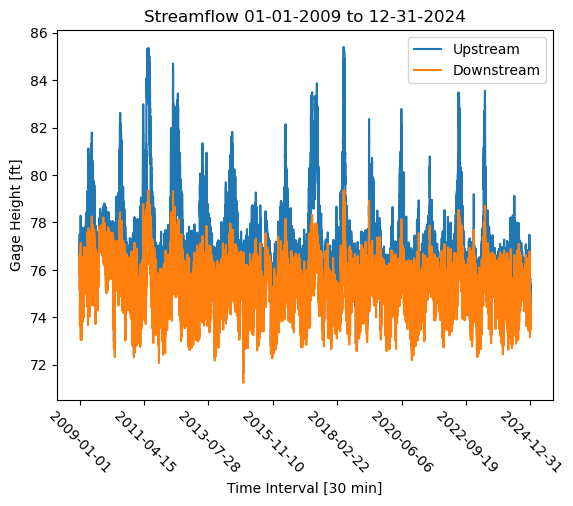

In [18]:
plt.plot(dates, x, label = 'Upstream')
plt.plot(dates, y, label = 'Downstream')

plt.title('Streamflow ' + date_range)
plt.xlabel("Time Interval [" + str(int_freq) + " min]")
plt.ylabel("Gage Height [ft]")
plt.legend()

# Set how many x-axis labels you want
num_labels_to_show = 8
# Calculate evenly spaced indices
indices = np.linspace(0, len(dates) - 1, num_labels_to_show, dtype=int)
selected_dates = dates[indices]

# Apply sampled ticks and rotated labels
ax = plt.gca()
ax.set_xticks(selected_dates)
ax.set_xticklabels(selected_dates.strftime('%Y-%m-%d'), rotation=-45)


plt.show()

### Plot #2: Detrended Streamflow

In [20]:
x_bar = x - np.mean(x)
y_bar = y - np.mean(y)

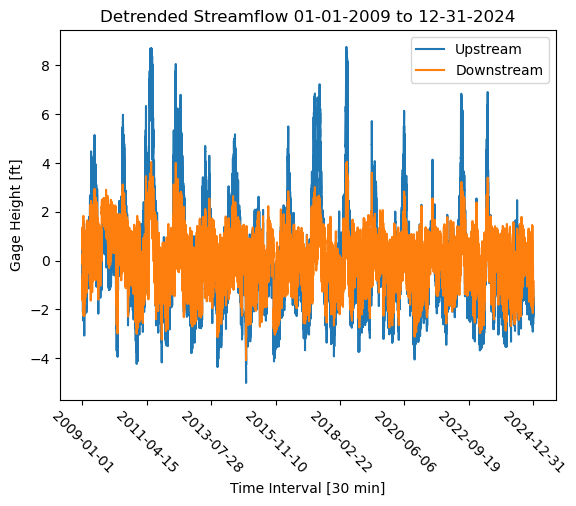

In [21]:
plt.plot(dates, x_bar, label = 'Upstream')
plt.plot(dates, y_bar, label = 'Downstream')

plt.title('Detrended Streamflow ' + date_range)
plt.legend()
plt.xlabel("Time Interval [" + str(int_freq) + " min]")
plt.ylabel("Gage Height [ft]")

# Apply sampled ticks and rotated labels
ax = plt.gca()
ax.set_xticks(selected_dates)
ax.set_xticklabels(selected_dates.strftime('%Y-%m-%d'), rotation=-45)

plt.show()

## Daily Cross-Correlation Analysis

In [23]:
max_lag = 72 # one day
correlations = [np.corrcoef(x[:-lag], y[lag:])[0,1] for lag in range(1, max_lag+1)]

best_lag = np.argmax(correlations) + 1  
print(f"Optimal delay: {best_lag*(int_freq/60)} hours") # convert min invervals to hours

Optimal delay: 2.0 hours


## Data Visualization: Postprocessing

### Plot #3: Detrended & Delagged Streamflow

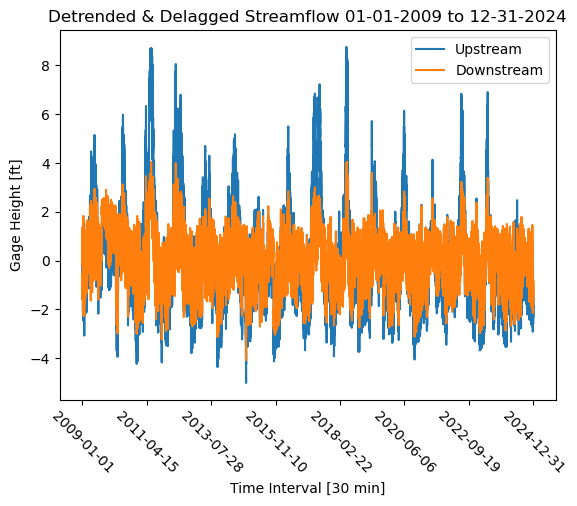

In [26]:
plt.plot(dates[:-best_lag], x_bar[:-best_lag], label = 'Upstream')
plt.plot(dates[best_lag:], y_bar[best_lag:], label = 'Downstream')
plt.title('Detrended & Delagged Streamflow ' + date_range)
plt.legend()
plt.xlabel("Time Interval [" + str(int_freq) + " min]")
plt.ylabel("Gage Height [ft]")

# Apply sampled ticks and rotated labels
ax = plt.gca()
ax.set_xticks(selected_dates)
ax.set_xticklabels(selected_dates.strftime('%Y-%m-%d'), rotation=-45)

plt.show()

### Plot #4a: Error

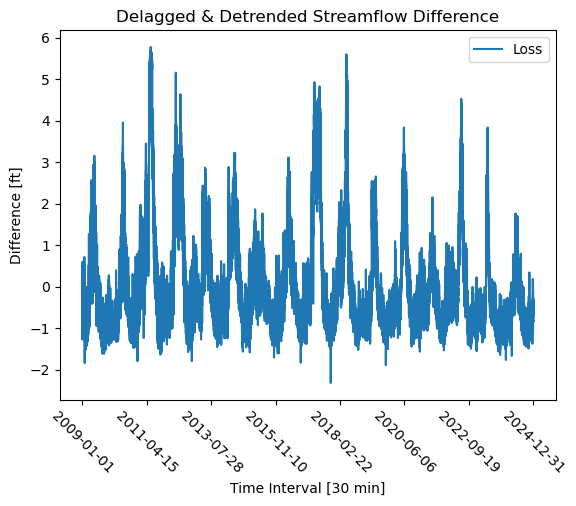

In [28]:
# loss from upstream to downstream 
loss = x_bar[:-best_lag]-y_bar[best_lag:]
plt.plot(dates[best_lag:], loss, label = 'Loss')
plt.title('Delagged & Detrended Streamflow Difference')
plt.legend()
plt.xlabel("Time Interval [" + str(int_freq) + " min]")
plt.ylabel("Difference [ft]")

# Apply sampled ticks and rotated labels
ax = plt.gca()
ax.set_xticks(selected_dates)
ax.set_xticklabels(selected_dates.strftime('%Y-%m-%d'), rotation=-45)

plt.show()

### Plot #4: Error Histogram

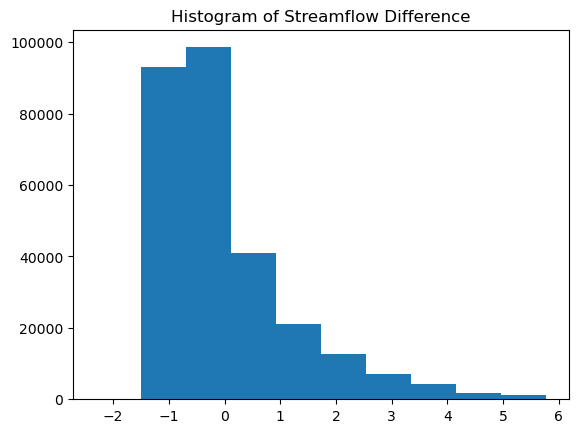

In [30]:
plt.hist(loss) # scatter
plt.title("Histogram of Streamflow Difference")
plt.show()

### Plot #5: Correlations

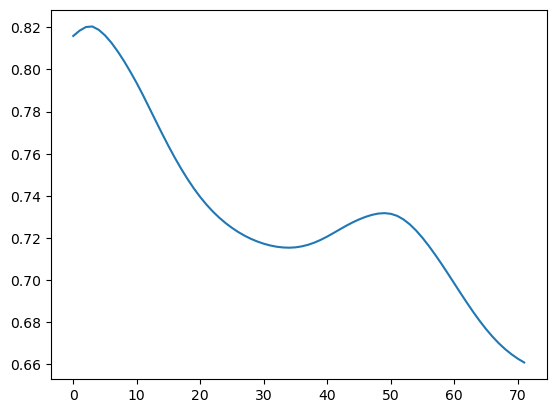

In [32]:
plt.plot(correlations)
plt.show()

## Cross-Correlation Distribution

In [34]:
# Parameters
intervals_per_day = int((60/int_freq)*24)  # 30-min data → 48 points/day
max_lag = int(intervals_per_day/4)  # Limit lag search to 12 hours
num_days = len(x) // intervals_per_day

# Store optimal lag per day
optimal_lags = []

for day in range(num_days-1):
    
    start = day * intervals_per_day 
    end = start + intervals_per_day + max_lag  # Extra for lagging

    # Skip if not enough data left for full lag window
    if end > len(x):
        break

    x_day = x[start:end]
    y_day = y[start:end]
    
    correlations = [np.corrcoef(x_day[:-lag], y_day[lag:])[0,1] for lag in range(1, max_lag+1)]
    best_lag = np.argmax(correlations) + 1
    optimal_lags.append(best_lag)

# Convert to numpy array and optionally to hours
optimal_lags = np.array(optimal_lags)
optimal_lags_hours = optimal_lags * (int_freq/60)  # convert min invervals to hours


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


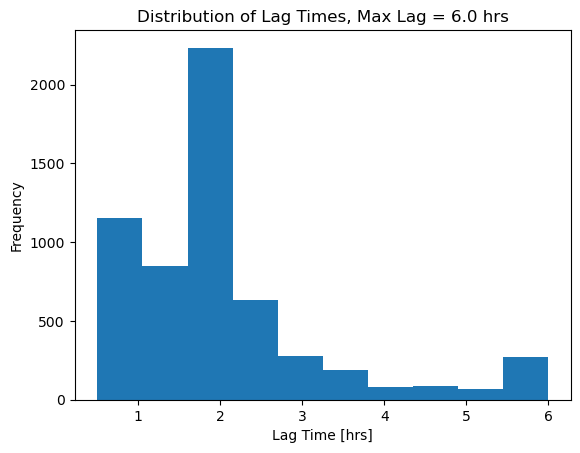

In [35]:
plt.hist(optimal_lags_hours, bins=10)
plt.title('Distribution of Lag Times, Max Lag = ' + str(max_lag/2) + ' hrs')
plt.ylabel('Frequency')
plt.xlabel('Lag Time [hrs]')
plt.show()

# Regression Visualization

In [37]:
month_start = '04-01'
month_end = '08-31'

train_start_date = '2008-' + month_start
train_end_date = '2023-' + month_end

test_start_date = '2024-' + month_start
test_end_date = '2024-' + month_end

In [38]:
# Isolate train and testing data
df_range = df[(df.index >= train_start_date)]

mask = (
    (df_range.index.strftime('%m-%d') >= month_start) &
    (df_range.index.strftime('%m-%d') <= month_end)
)

df_range = df_range[mask]
df_range = df_range.rename(columns={'00065': 'y'}) ## df: inflow downstream

# Merge in upstream data
df_range = df_range.merge(df2, left_index=True, right_index=True, how='inner')
df_range = df_range.rename(columns={'00065': 'x'})
df_range = df_range[['y', 'x']]

# Calculate day of year as feature
df_range['DoY'] = pd.to_datetime(df_range.index).strftime('%j').astype(int)

In [39]:
# Normalize features
scaler = StandardScaler()
df_range_norm = scaler.fit_transform(df_range)

# col 1: y
df_range['y_norm'] = df_range_norm[:,0]
# col 2: x
df_range['x_norm'] = df_range_norm[:,1]
# col 3: DoY
df_range['DoY_norm'] = df_range_norm[:,2]

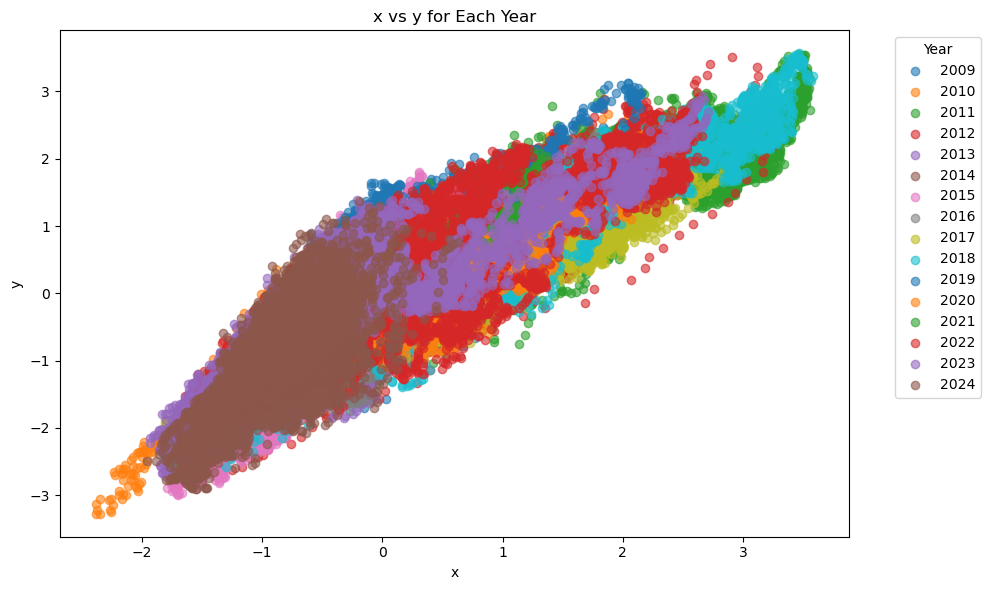

In [40]:
# Make a copy to avoid modifying df_train
df_plot = df_range.copy()

# Group by year from the datetime index
df_plot['year'] = df_plot.index.year

plt.figure(figsize=(10, 6))

for year, group in df_plot.groupby('year'):
    plt.scatter(group['x_norm'], group['y_norm'], label=str(year), alpha=0.6)

plt.xlabel('x')
plt.ylabel('y')
plt.title('x vs y for Each Year')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

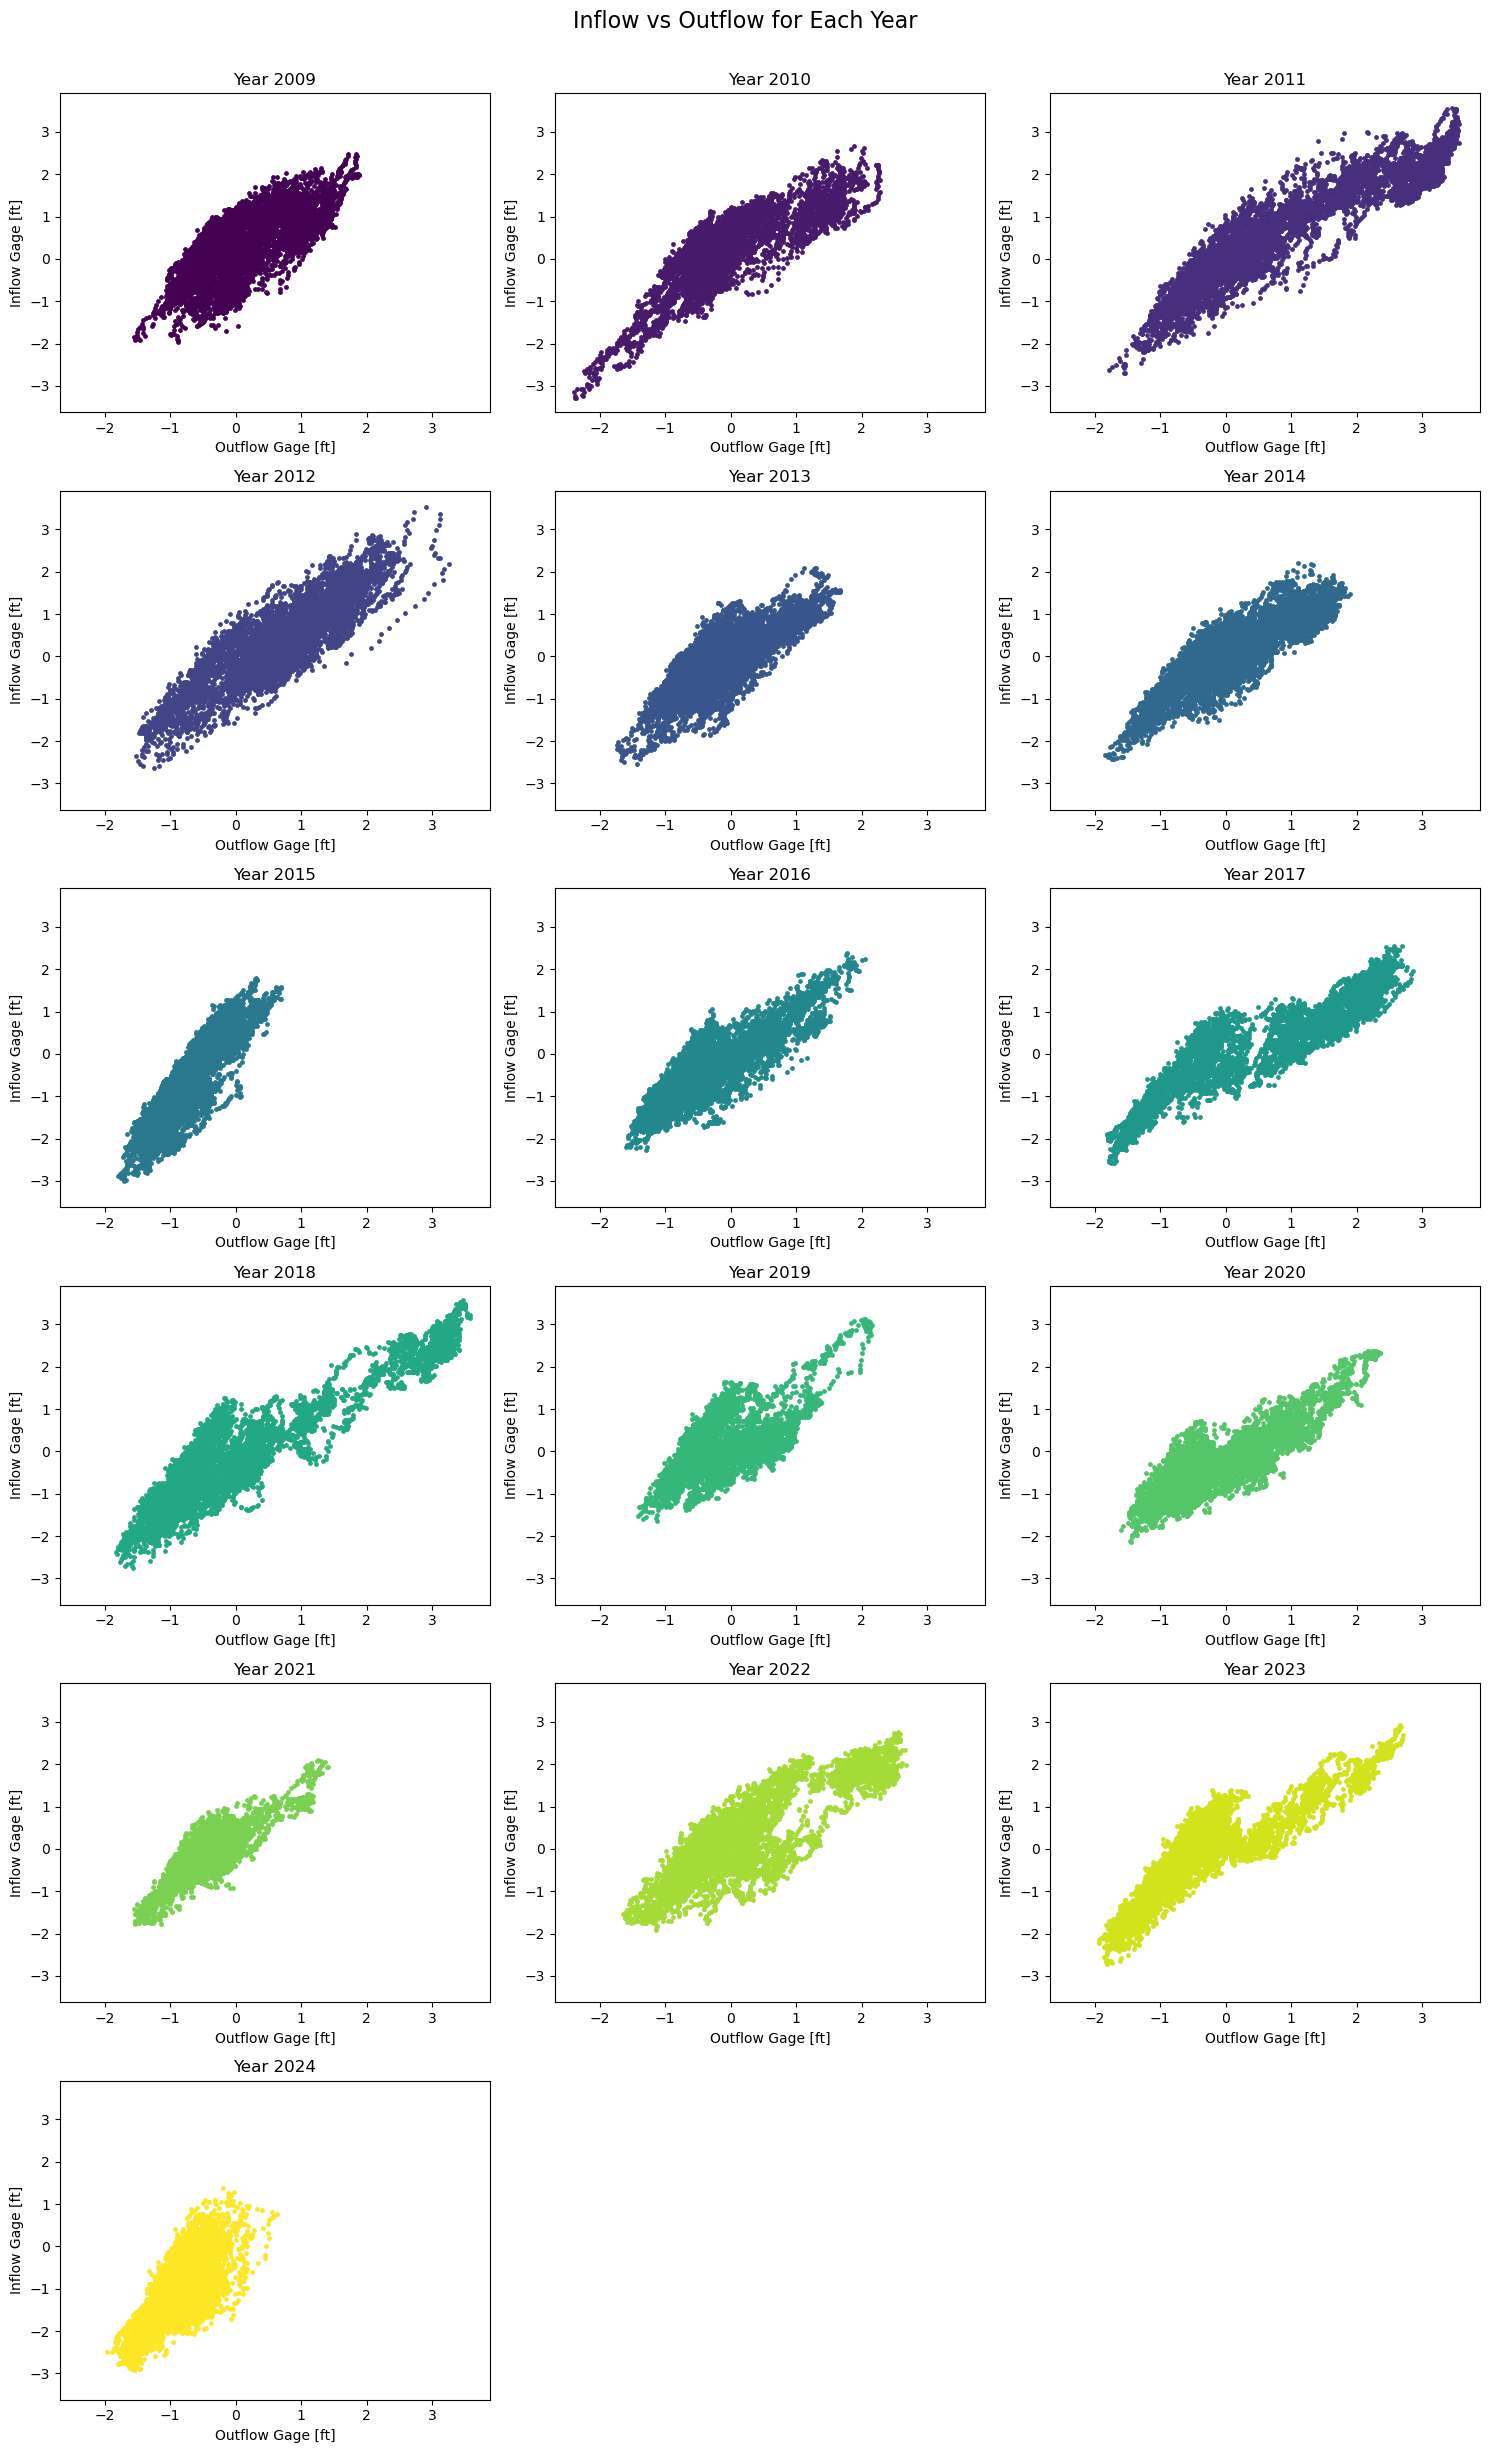

In [41]:
# Step 1: Copy df_train to df_plot
# Step 2: Add 'year' column

# Step 3: Prepare years and subplot grid
years = sorted(df_plot['year'].unique())
n_years = len(years)
n_cols = 3
n_rows = math.ceil(n_years / n_cols)

# Step 4: Generate colormap
cmap = plt.colormaps['viridis']   # Or try 'viridis', 'plasma', 'turbo', etc.
colors = [cmap(i / max(n_years - 1, 1)) for i in range(n_years)]  # Normalize to [0,1]

# Step 5: Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    yearly_data = df_plot[df_plot['year'] == year]
    ax.scatter(yearly_data['x_norm'], yearly_data['y_norm'], color=colors[i], label=str(year), s = 6)
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Outflow Gage [ft]')
    ax.set_ylabel('Inflow Gage [ft]')

    # Force x-tick labels to be visible
    ax.tick_params(labelbottom=True, labelleft=True)

# Step 6: Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Inflow vs Outflow for Each Year', fontsize=16, y=1.02)
plt.show()


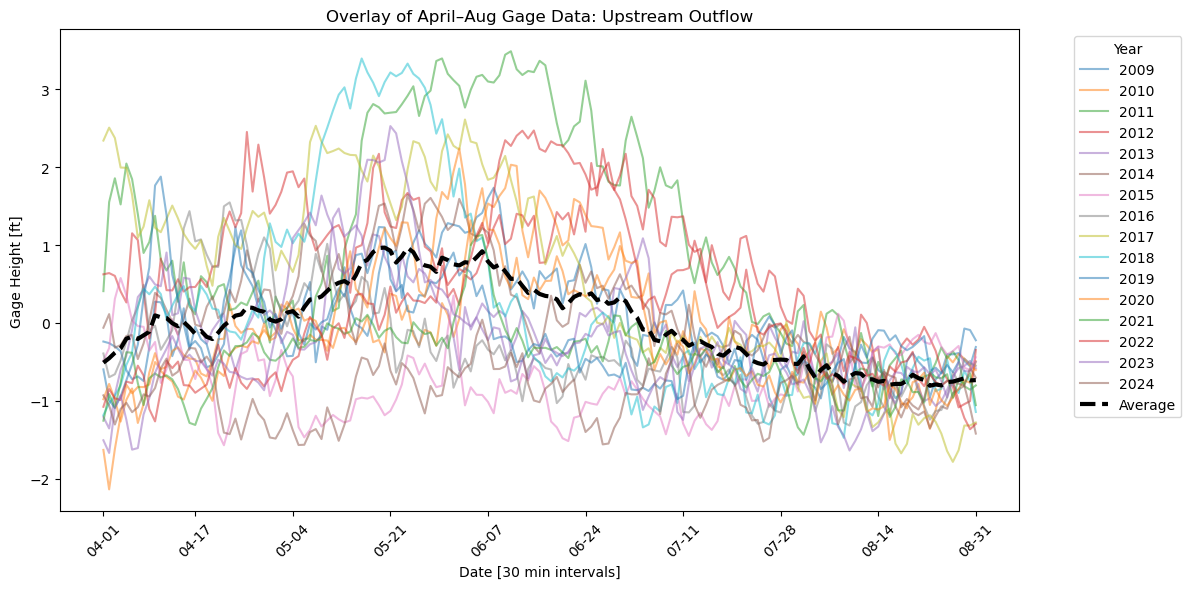

In [42]:
# Add day-of-year markers
df_plot['day_of_year'] = df_plot.index.strftime('%m-%d')

# Pivot data
pivot = df_plot.pivot_table(index='day_of_year', columns='year', values='x_norm')

# Sort index to ensure proper plotting order
pivot = pivot.sort_index()

# Compute mean across all years
mean_series = pivot.mean(axis=1)

# Plot all years
plt.figure(figsize=(12, 6))
for year in pivot.columns:
    plt.plot(pivot.index, pivot[year], label=str(year), alpha=0.5)

# Plot average line
plt.plot(pivot.index, mean_series, label='Average', color='black', linestyle='--', linewidth=3)

# Show only 10 evenly spaced x-axis labels
xticks_idx = np.linspace(0, len(pivot.index) - 1, 10, dtype=int)
xticks_labels = pivot.index[xticks_idx]
plt.xticks(xticks_idx, xticks_labels, rotation=45)

plt.xlabel('Date [' + str(int_freq) + ' min intervals]')
plt.ylabel('Gage Height [ft]')
plt.title('Overlay of April–Aug Gage Data: Upstream Outflow')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Regression Analysis

In [340]:
df_range.tail()

,y,x,DoY,y_norm,x_norm,DoY_norm
datetime,,,,,,
2024-08-31 21:30:00,75.83,76.41,244,0.134952,-0.641723,1.737665
2024-08-31 22:00:00,75.92,76.46,244,0.222454,-0.618237,1.737665
2024-08-31 22:30:00,76.11,76.08,244,0.407179,-0.796725,1.737665
2024-08-31 23:00:00,76.19,76.22,244,0.484958,-0.730967,1.737665
2024-08-31 23:30:00,76.25,76.24,244,0.543293,-0.721573,1.737665


## Looped Lag Selection via Residual Scatter Plots

In [46]:
def lag_selection_via_residuals(upstream, downstream, max_lag=10):
    df = pd.DataFrame({'downstream': downstream})
    for lag in range(1, max_lag + 1):
        df[f'upstream_lag{lag}'] = upstream.shift(lag)
    
    df.dropna(inplace=True)
    X_cols = []
    selected_lags = []

    # Plot setup
    n_plots = max_lag - 1
    n_cols = 3
    n_rows = math.ceil(n_plots / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axs = axs.flatten()

    for lag in range(1, max_lag):
        lag_col = f'upstream_lag{lag}'
        next_lag_col = f'upstream_lag{lag + 1}'
        X_cols.append(lag_col)
        selected_lags.append(lag_col)

        model = LinearRegression().fit(df[X_cols], df['downstream'])
        df['residual'] = df['downstream'] - model.predict(df[X_cols])

        ax = axs[lag - 1]
        ax.scatter(df[next_lag_col], df['residual'], alpha=0.6)
        ax.set_title(f'Residual vs. {next_lag_col}')
        ax.set_xlabel(next_lag_col)
        ax.set_ylabel('Residual')
        ax.grid(True)

    for i in range(n_plots, len(axs)):
        fig.delaxes(axs[i])

    fig.tight_layout()
    plt.show()

    return model, selected_lags


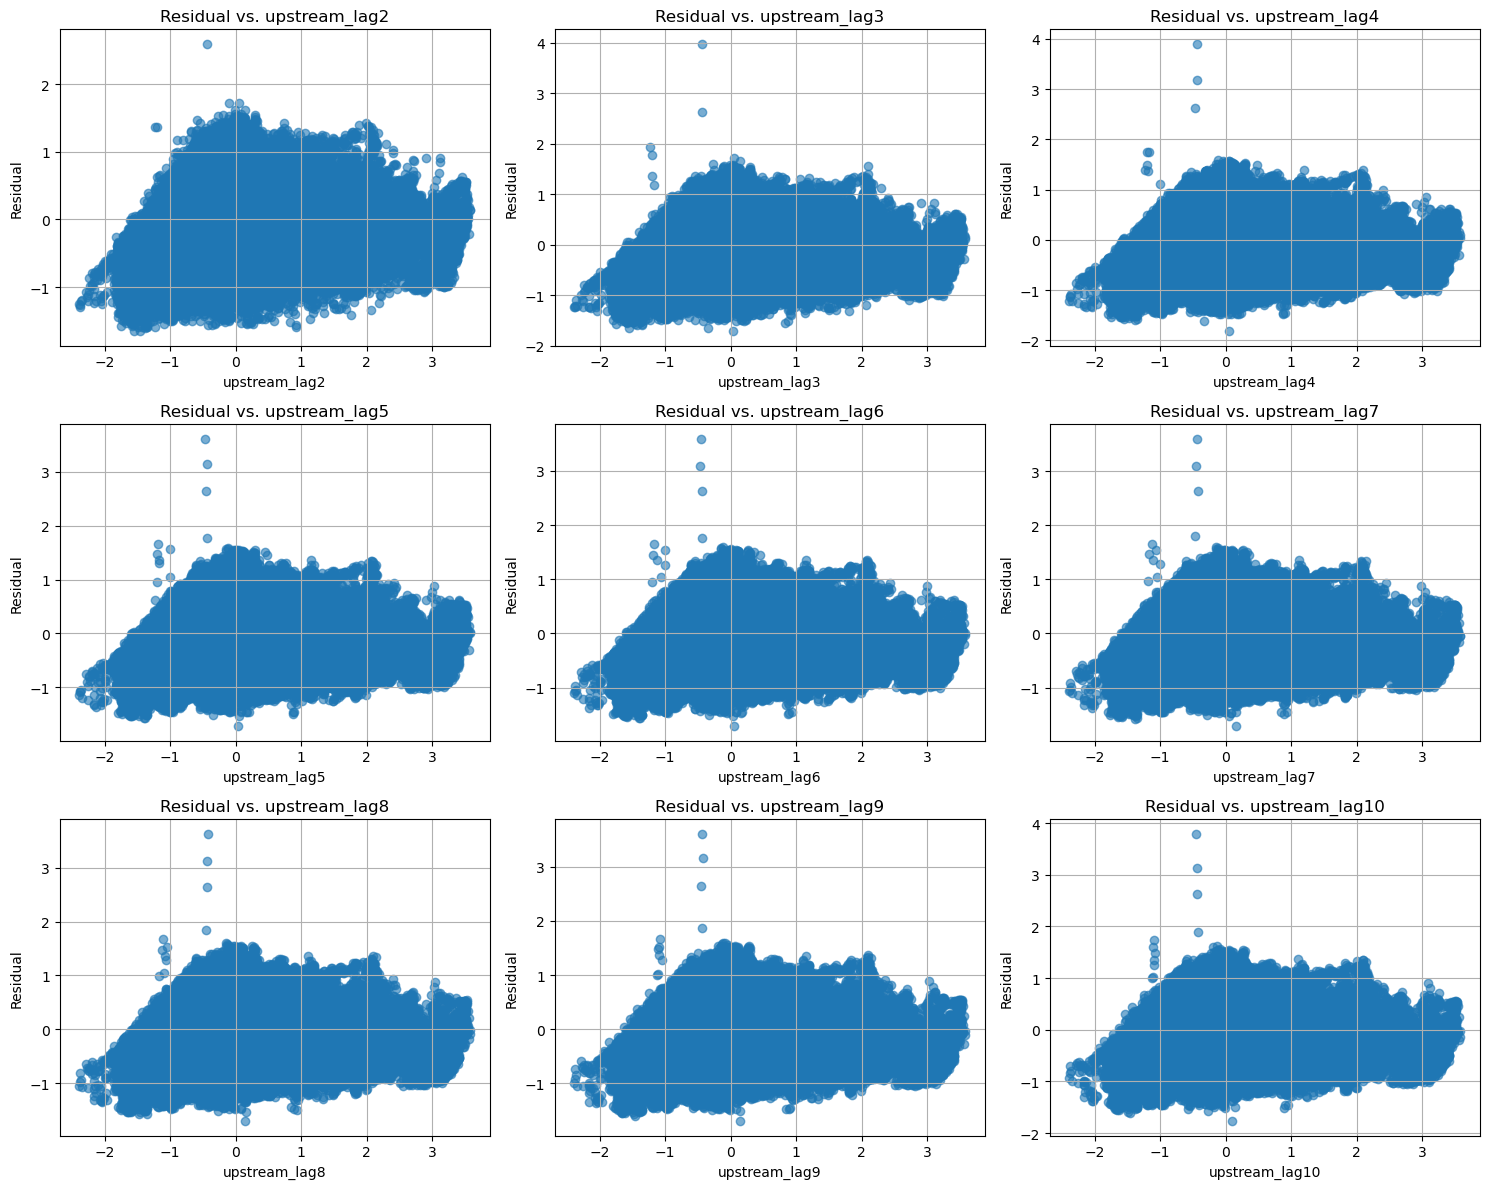

In [47]:
upstream = df_range['x_norm'].copy()
downstream = df_range['y_norm'].copy()

_, selected_lags = lag_selection_via_residuals(upstream, downstream)

## AR(p) Model to predict Inflow

In [342]:
df_reg = df_range.copy()

p = 12 # 6 hours

# Adding lag features to the DataFrame
for i in range(1, p):  # Creating lag features up to p days
    df_reg[f'X_Lag_{i}'] = df_reg['x_norm'].shift(i)

# Drop rows with NaN values resulting from creating lag features
df_reg.dropna(inplace=True)
df_reg = df_reg.rename(columns={1: '1'})

# Split the data into training and testing sets
train_data = df_reg[(df_reg.index <= train_end_date)]
test_data = df_reg[(df_reg.index >= test_start_date)]

# Define features and target
feature_cols = ['x_norm', 'DoY_norm'] + [f'X_Lag_{lag}' for lag in range(1, 12)]
X_train = train_data[feature_cols]
y_train = train_data['y_norm']

In [344]:
X_test = test_data[feature_cols]
y_test = test_data['y_norm']

In [348]:
X_test.head()

,x_norm,DoY_norm,X_Lag_1,X_Lag_2,X_Lag_3,X_Lag_4,X_Lag_5,X_Lag_6,X_Lag_7,X_Lag_8,X_Lag_9,X_Lag_10,X_Lag_11
datetime,,,,,,,,,,,,,
2024-04-01 00:00:00,-0.726270,-1.703704,-0.575964,-0.359899,-0.359899,-0.284747,-0.289444,-0.251867,-0.251867,-0.284747,-0.331717,-0.350505,-0.345808
2024-04-01 00:30:00,-0.857787,-1.703704,-0.726270,-0.575964,-0.359899,-0.359899,-0.284747,-0.289444,-0.251867,-0.251867,-0.284747,-0.331717,-0.350505
2024-04-01 01:00:00,-0.862484,-1.703704,-0.857787,-0.726270,-0.575964,-0.359899,-0.359899,-0.284747,-0.289444,-0.251867,-0.251867,-0.284747,-0.331717
2024-04-01 01:30:00,-0.914152,-1.703704,-0.862484,-0.857787,-0.726270,-0.575964,-0.359899,-0.359899,-0.284747,-0.289444,-0.251867,-0.251867,-0.284747
2024-04-01 02:00:00,-0.928243,-1.703704,-0.914152,-0.862484,-0.857787,-0.726270,-0.575964,-0.359899,-0.359899,-0.284747,-0.289444,-0.251867,-0.251867


In [52]:
# sklearn linear regression

# model = LinearRegression()
# model.fit(X_train, y_train)

In [350]:
import statsmodels.api as sm

# Step 1: Add constant (intercept)
X_train_const = sm.add_constant(X_train)

# Step 2: Fit OLS model
model = sm.OLS(y_train, X_train_const).fit(cov_type='HC1') # Heteroskedasticity-consistent

# Step 3: View summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 y_norm   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.794e+04
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        13:59:36   Log-Likelihood:                -76063.
No. Observations:              110102   AIC:                         1.522e+05
Df Residuals:                  110088   BIC:                         1.523e+05
Df Model:                          13                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0162      0.001     11.012      0.0

In [352]:
residuals = model.resid
fitted_vals = model.fittedvalues

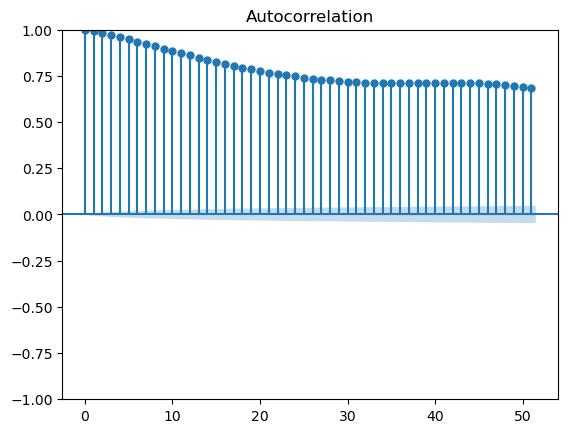

In [354]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals)
plt.show()

### Checking for Heteroskedasticity 

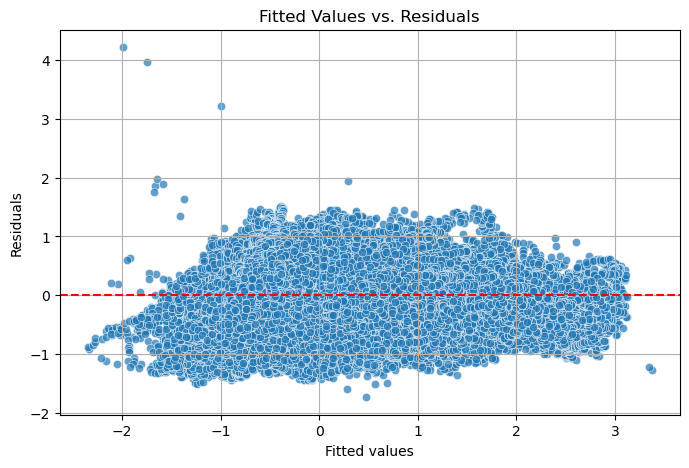

In [356]:
# 1. Residuals vs. Fitted Plot

plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Fitted Values vs. Residuals")
plt.grid(True)
plt.show()

In [358]:
# 2. Breusch-Pagan Test: tests if residual variance is dependent on fitted values

bp_test = sms.het_breuschpagan(residuals, X_train_const)

bp_labels = ['Lagrange multiplier statistic', 'p-value', 
             'f-value', 'f p-value']
print("\nBreusch-Pagan test results:")
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.4f}")


Breusch-Pagan test results:
Lagrange multiplier statistic: 1194.0948
p-value: 0.0000
f-value: 92.8487
f p-value: 0.0000


### Evaluation on Test Data

In [361]:
X_test_const = sm.add_constant(X_test)  # Add intercept term
X_test_const['const'] = np.ones(len(X_test))
X_test_const = pd.DataFrame(X_test_const, columns=model.model.exog_names)
y_pred = model.predict(X_test_const)

In [363]:
# Evaluate Performance 

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'R²: {r2:.3f}')

RMSE: 0.575
MAE: 0.483
R²: 0.442


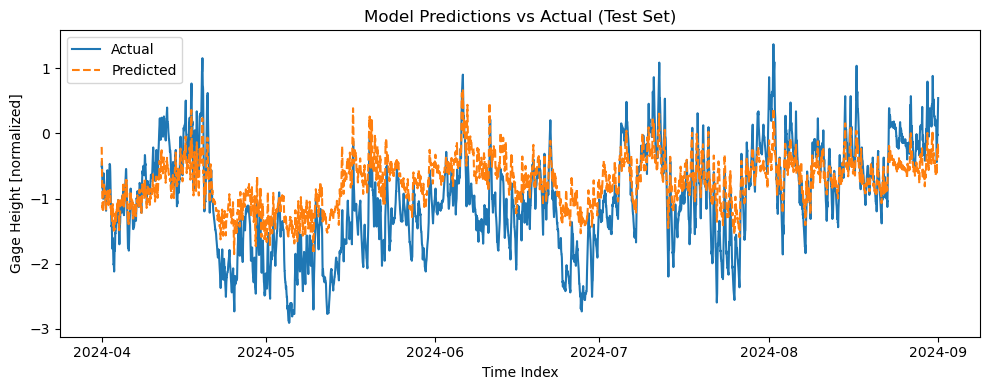

In [369]:
plt.figure(figsize=(10, 4))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred.values, label='Predicted', linestyle='--')
plt.title('Model Predictions vs Actual (Test Set)')
plt.legend()
plt.xlabel('Time Index')
plt.ylabel('Gage Height [normalized]')
plt.tight_layout()
plt.show()

## Residual Analysis

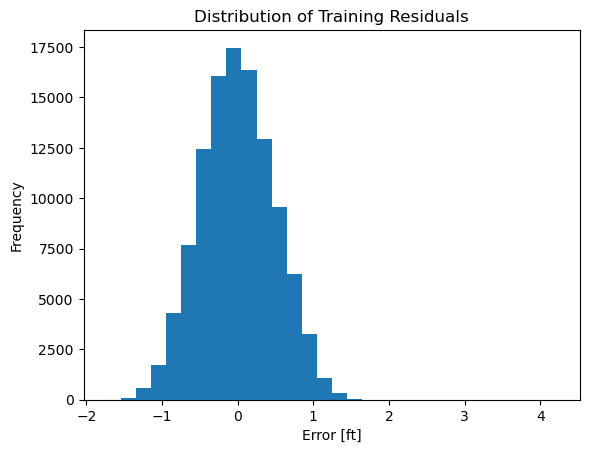

In [367]:
plt.hist(residuals.to_numpy(), bins = 30)
plt.title('Distribution of Training Residuals')
plt.ylabel('Frequency')
plt.xlabel('Error [ft]')
plt.show()

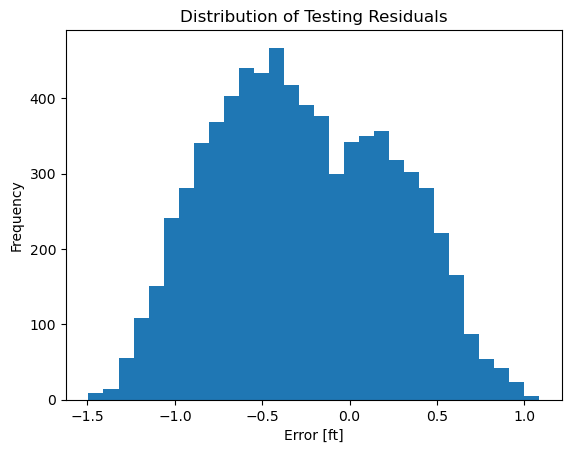

In [373]:
test_residuals = y_test - y_pred
plt.hist(test_residuals, bins = 30)
plt.title('Distribution of Testing Residuals')
plt.ylabel('Frequency')
plt.xlabel('Error [ft]')
plt.show()

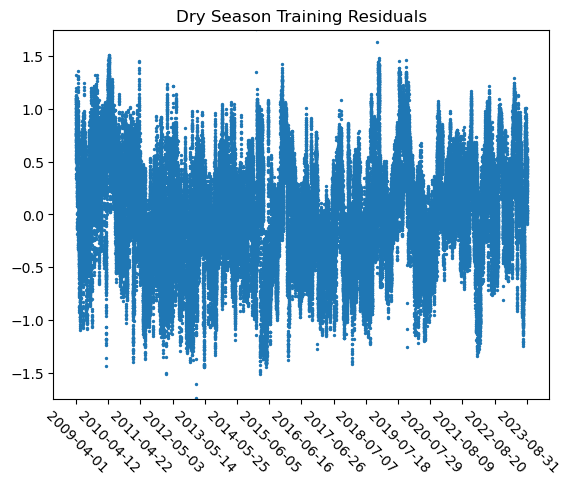

In [375]:
date_strings = X_train.index.strftime('%Y-%m-%d').to_numpy()

plt.scatter(date_strings, residuals.to_numpy(), s = 2)

# Set how many x-axis labels you want
num_labels_to_show = 15

# Calculate evenly spaced indices
indices = np.linspace(0, len(date_strings) - 1, num_labels_to_show, dtype=int)
selected_dates = date_strings[indices]

# Apply sampled ticks and rotated labels
ax = plt.gca()
ax.set_xticks(selected_dates)
ax.set_xticklabels(selected_dates, rotation=-45)
ax.set_ylim([-1.75, 1.75])

plt.title("Dry Season Training Residuals")
plt.show()

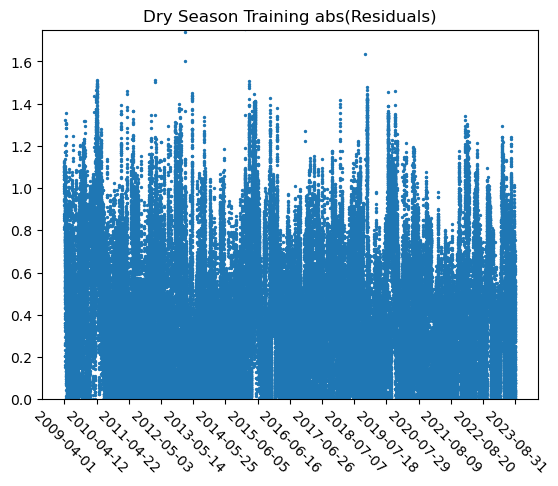

In [377]:
plt.scatter(date_strings, abs(residuals.to_numpy()), s = 2)

# Apply sampled ticks and rotated labels
ax = plt.gca()
ax.set_xticks(selected_dates)
ax.set_xticklabels(selected_dates, rotation=-45)
ax.set_ylim([0, 1.75])

plt.title("Dry Season Training abs(Residuals)")

plt.show()

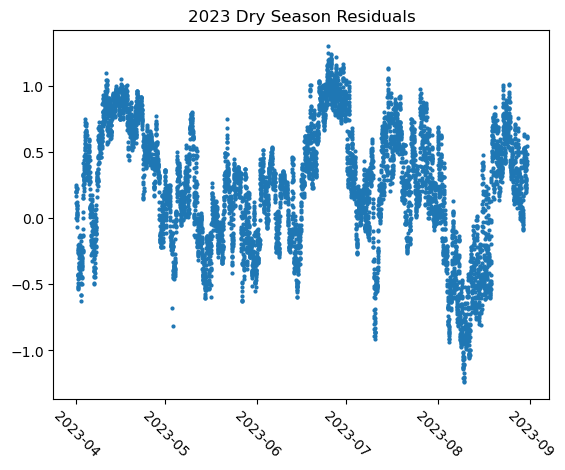

In [379]:
## Scatter the residuals for the final year

index23 = X_train[X_train.index >= '2023-' + month_start].index
res23 = residuals[len(residuals)-len(index23):]

plt.scatter(index23, res23, s =4)
plt.title("2023 Dry Season Residuals")
plt.xticks(rotation=-45)
plt.show()

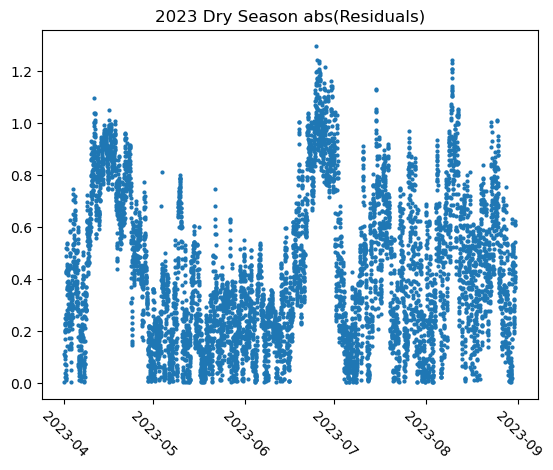

In [381]:
## Scatter the abs(residuals) for the final year

plt.scatter(index23, abs(res23), s =4)
plt.title("2023 Dry Season abs(Residuals)")
plt.xticks(rotation=-45)
plt.show()

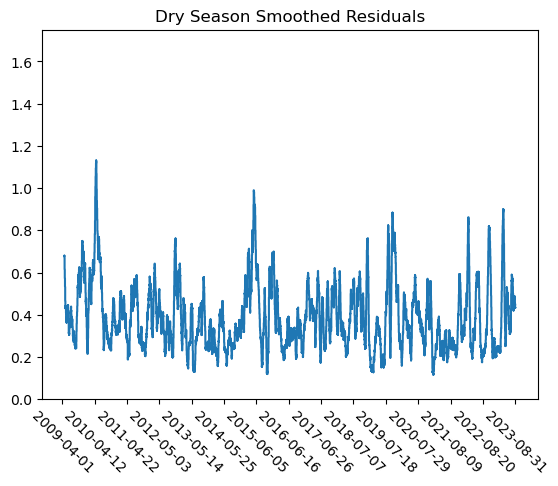

In [383]:
## Plot the smoothed residuals for the final year

win = 500

plt.plot(date_strings, abs(residuals).rolling(window=win).mean())

# Apply sampled ticks and rotated labels
ax = plt.gca()
ax.set_xticks(selected_dates)
ax.set_xticklabels(selected_dates, rotation=-45)
ax.set_ylim([0, 1.75])

plt.title("Dry Season Smoothed Residuals")

plt.show()

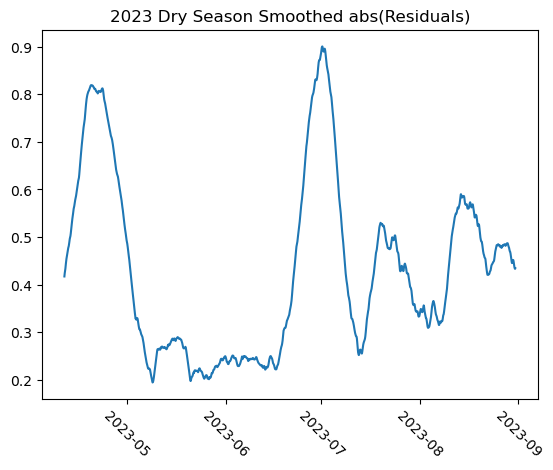

In [385]:
## Plot the smoothed residuals for the final year

plt.plot(index23, abs(res23).rolling(window=win).mean() )
plt.title("2023 Dry Season Smoothed abs(Residuals)")
plt.xticks(rotation=-45)
plt.show()

# ARIMAX Model

In [71]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = max_lag
d = 5 # differencing
q = 2

# y = downstream inflow
# X = matrix of lagged upstream outflows
# ARIMA_model = SARIMAX(y_train, exog=X_train, order=(p, d, q))
# AR_results = ARIMA_model.fit()
# print(AR_results.summary())

# write a full block of code that does lagging, stationarity testing, and grid search over q?

# Predicting Residuals

In [388]:
y_res = abs(residuals).rolling(window=win).mean()

In [390]:
# Drop any NaNs from lag alignment
garch_df = pd.concat([X_train, y_res], axis=1).dropna()

X = garch_df['x_norm']
y = garch_df[0]

In [392]:
from arch import arch_model

# Fit a GARCH(p,q) model with exogenous regressors
garch_model = arch_model(
    y, 
    x=X, 
    mean='LS',       # Least Squares for conditional mean
    vol='GARCH',     # GARCH model for conditional variance
    p=1, q = 1,          # GARCH(max_lag,1)
    rescale=True
)

garch_model_fit = garch_model.fit(disp="off")
print(garch_model_fit.summary())


                     Least Squares - GARCH Model Results                      
Dep. Variable:                      0   R-squared:                      -0.166
Mean Model:             Least Squares   Adj. R-squared:                 -0.166
Vol Model:                      GARCH   Log-Likelihood:               -138163.
Distribution:                  Normal   AIC:                           276335.
Method:            Maximum Likelihood   BIC:                           276383.
                                        No. Observations:               109603
Date:                Wed, May 07 2025   Df Residuals:                   109601
Time:                        14:12:19   Df Model:                            2
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const          3.2585  5.593e-03    582.635      0.000    

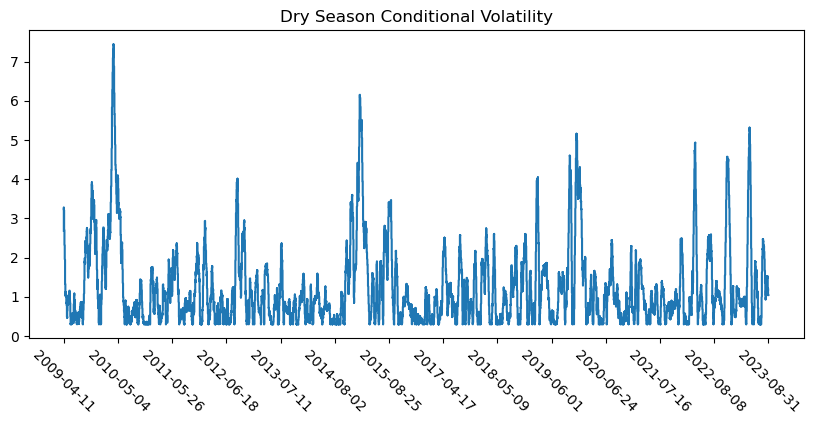

In [394]:
res_date_strings = date_strings[(win-1):].copy()

plt.figure(figsize=(10, 4))
plt.plot(res_date_strings, garch_model_fit.conditional_volatility)

# Apply sampled ticks and rotated labels
ax = plt.gca()

# Calculate evenly spaced indices
num_labels_to_show = 14
indices = np.linspace(0, len(res_date_strings) - 1, num_labels_to_show, dtype=int)
selected_dates = res_date_strings[indices]

# Apply sampled ticks and rotated labels
ax = plt.gca()
ax.set_xticks(selected_dates)
ax.set_xticklabels(selected_dates, rotation=-45)
plt.title("Dry Season Conditional Volatility")

plt.show()

# Forecasting Test Set with LinReg + GARCH

In [397]:
# y_pred gives the mean forecast at each time step

# Forecast residuals from GARCH
y_hat = garch_model_fit.forecast(x=X_test['x_norm'], horizon=len(X_test))

In [399]:
# Conditional variance

cond_var = y_hat.variance.values[-1]  # Last row contains forecast for len(X_test)
cond_vol = np.sqrt(cond_var)

# So the streamflow at each step is modeled as:
# Y_t ~ Normal(mean=y_pred[t], std=cond_vol[t])

In [401]:
# 95% confidence interval
upper = y_pred + 1.96 * cond_vol
lower = y_pred - 1.96 * cond_vol

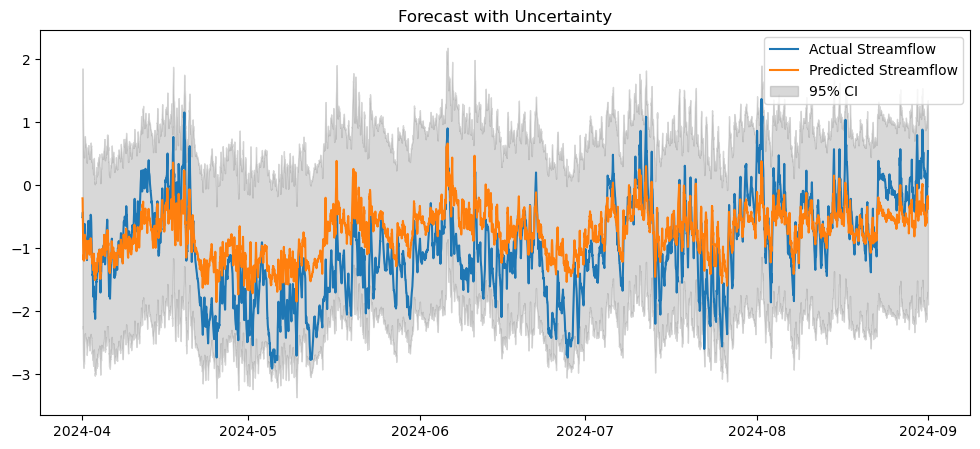

In [403]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label="Actual Streamflow")
plt.plot(y_test.index, y_pred, label="Predicted Streamflow")
plt.fill_between(y_test.index, lower, upper, color='gray', alpha=0.3, label="95% CI")
plt.legend()
plt.title("Forecast with Uncertainty")
plt.show()